##### **Mildew Detection in Cherry Leaves**

# Modelling and evalutation

## Objectives

* Answer business requirement 2:
* The client is interested to tell whether a given leaf is infested or not

## Inputs

* inputs/cherry-leaves/leaf_images/train
* inputs/cherry-leaves/leaf_images/validation
* inputs/cherry-leaves/leaf_images/test
* image shape embeddings

## Outputs

* Images distribution plot in train, validation and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Machine learning model saving
* Learning curve plot for model performance
* Save model evaluation to pickle file
* Prediction on the random image file


---

#### Import libraries

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

#### Set working directiory

In [26]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection'

In [ ]:
os.chdir('/workspaces/mildew-detection')
print("You set a new current directory")

In [ ]:
current_dir = os.getcwd()
current_dir

## Input directories

#### Set train, validation and test paths

In [27]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Output directory

#### Set output directory

In [29]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available, create a new version.')
    pass
else:
    os.makedirs(name=file_path)

#### Set labels

In [30]:
labels = os.listdir(train_path)

print(f"Project Labels: {labels}")

Project Labels: ['healthy', 'powdery_mildew']


#### Set image shape

Import saved image shape embedding from pickle file

In [32]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

#### Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




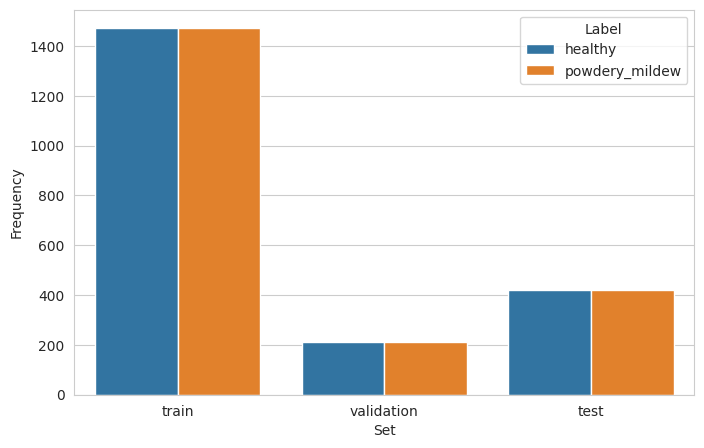

In [33]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image data augmentation

Introducing the ImageDataGenerator from Tensorflow

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Initialize the ImageDataGenerator

In [35]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

Augment training image dataset

In [36]:
# Set batch size
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )
train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment validation image dataset

In [37]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )
validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment test image dataset

In [38]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )
test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Plot augmented training images

(20, 256, 256, 3)


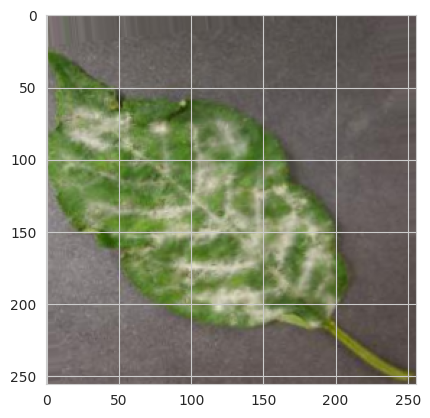

(20, 256, 256, 3)


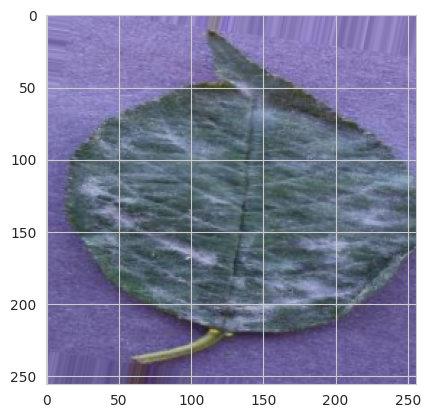

(20, 256, 256, 3)


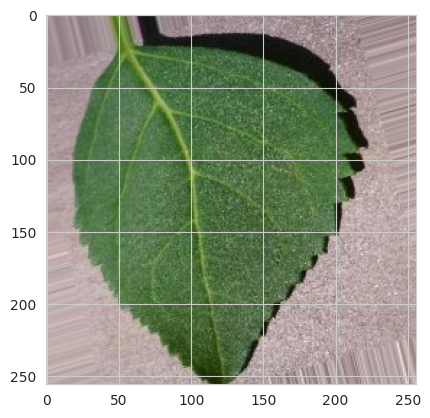

In [39]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented validation images

(20, 256, 256, 3)


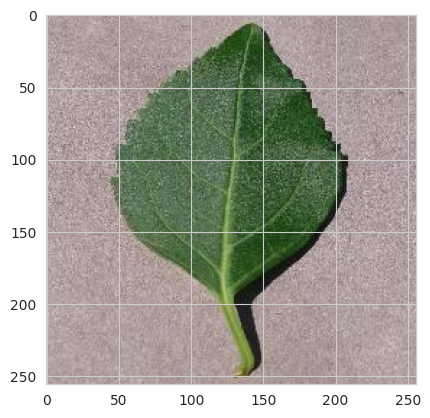

(20, 256, 256, 3)


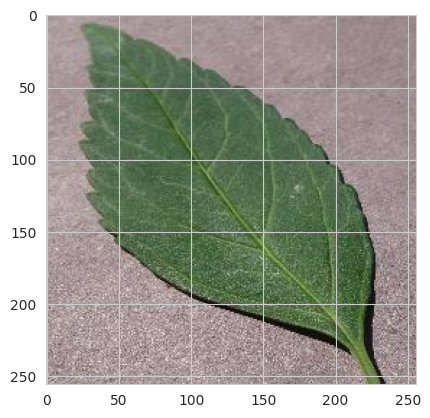

(20, 256, 256, 3)


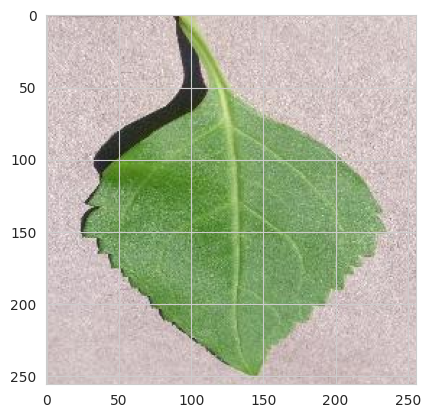

In [41]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented test images

(20, 256, 256, 3)


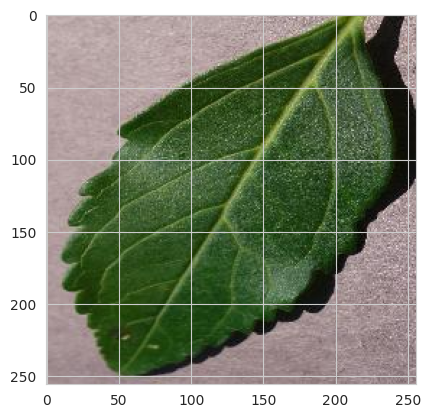

(20, 256, 256, 3)


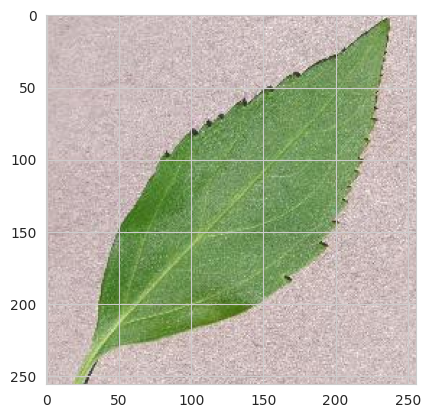

(20, 256, 256, 3)


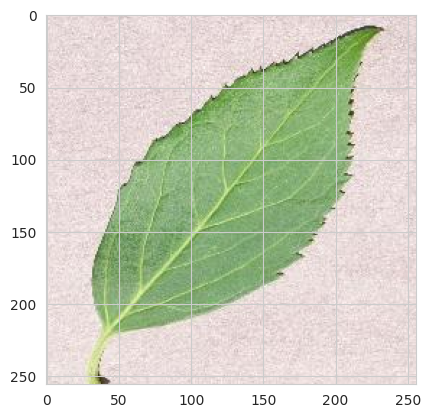

In [42]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Save class_indices to pickle file

In [43]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v2/class_indices.pkl']

## Model creation

#### Machine learning model

Import model packages

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D


### **DAS MODEL**

In [45]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

Model summary

In [46]:
create_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)            

Early stopping

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

#### Fit model for model training

In [48]:
model = create_tf_model()
model.fit(train_set,
          epochs=5,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/5
147/147 [==============================] - 278s 2s/step - loss: 0.3438 - accuracy: 0.8266 - val_loss: 0.0806 - val_accuracy: 0.9881
Epoch 2/5
147/147 [==============================] - 271s 2s/step - loss: 0.0882 - accuracy: 0.9737 - val_loss: 0.0585 - val_accuracy: 0.9929
Epoch 3/5
147/147 [==============================] - 317s 2s/step - loss: 0.0567 - accuracy: 0.9839 - val_loss: 0.0486 - val_accuracy: 0.9952
Epoch 4/5
147/147 [==============================] - 298s 2s/step - loss: 0.0355 - accuracy: 0.9904 - val_loss: 0.0239 - val_accuracy: 0.9952
Epoch 5/5
147/147 [==============================] - 270s 2s/step - loss: 0.0620 - accuracy: 0.9808 - val_loss: 0.0065 - val_accuracy: 0.9976


#### Save model

In [49]:
model.save('outputs/v2/mildew_detection_model.h5')

## Model performance

#### Model learning curve

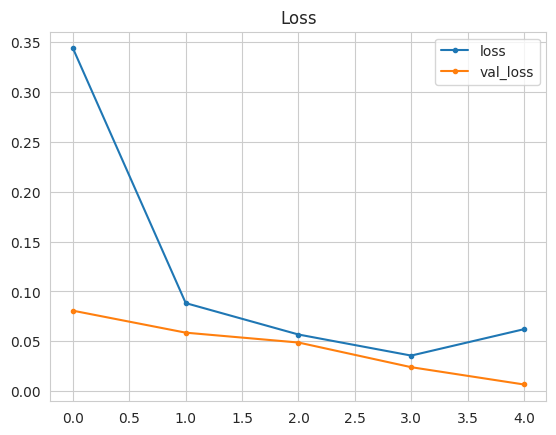

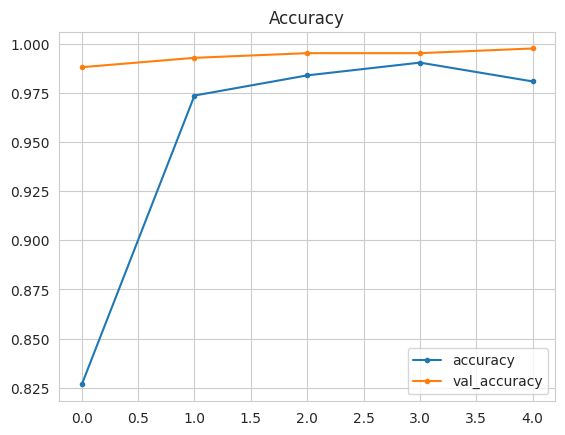

In [50]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model evaluation

Load saved model

In [51]:
from keras.models import load_model
model = load_model('outputs/v2/mildew_detection_model.h5')

Evaluate model on test set

In [52]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 19s 426ms/step - loss: 0.0377 - accuracy: 0.9929


Save evaluation to pickle file

In [53]:
joblib.dump(value=evaluation,
            filename=f"outputs/v2/evaluation.pkl")

['outputs/v2/evaluation.pkl']

### Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


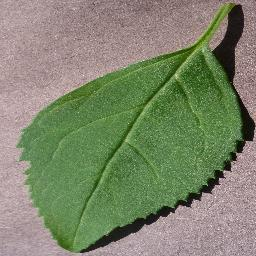

In [54]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [55]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [56]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999997436828494
healthy


---

# Great work. That's it!

---